In [30]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import numpy as np
import cv2
from PIL import Image

from scipy.signal import resample, chirp
from sklearn.linear_model import Ridge, ElasticNet

import naplib as nl
from naplib.visualization import strf_plot

In [31]:
test_data = loadmat("test_data/test.mat")
test_data = test_data['data']

# use frame index as first dimension
test_data = test_data.transpose((2, 0, 1))
print(test_data.shape)
height, width = test_data[1], test_data[2]

(420, 170, 152)


In [32]:
# # make movie
# frame_size = test_data.shape[1:3]

# out_lossless = cv2.VideoWriter('test_video.mkv',cv2.VideoWriter_fourcc(*'FFV1'), 100, (frame_size[1], frame_size[0]))
# out_lossy = cv2.VideoWriter('test_video_lossy.mkv',cv2.VideoWriter_fourcc(*'VP90'), 100, (frame_size[1], frame_size[0]))

# cm_test_data = np.copy(test_data)

# bwr_cm = cm.get_cmap('bwr')
# cm_test_data = bwr_cm((test_data - np.min(test_data)) / (np.max(test_data) - np.min(test_data)))

# cm_test_data = (cm_test_data[:, :, :, :3]*255).astype(np.uint8)

# example_images = 100, 250, 400

# for index, frame in enumerate(cm_test_data):
#     if index in example_images:
#         cv2.imwrite(f"images/frame_{index}.png", frame)
#     out_lossless.write(frame)
#     out_lossy.write(frame)
# out_lossless.release()
# out_lossy.release()

In [33]:
# load test stimulus
temp_test_stimulus = loadmat("test_data/stimulus.mat")
temp_test_stimulus = temp_test_stimulus['values'][0]
test_stimulus = []

for index, trial in enumerate(temp_test_stimulus):
    test_stimulus.append([])
for index, trial in enumerate(temp_test_stimulus):
    parseq_list = []
    for parseq in trial[0]:
        parseq_list.append(parseq[1][0])
    test_stimulus[index] = parseq_list

In [34]:
#
import os, math
from sklearn.preprocessing import MinMaxScaler
animal_id = 219
recording_id = 25
trial_id = 1
results_dir = f"../thesis_text/Imgs/m{animal_id}_r{recording_id}_t{trial_id}"
if not os.path.isdir(results_dir):
	os.makedirs(results_dir)

drc_stimulus = []
sr_audio = 250000
tone_duration = 12500/sr_audio
amplitude = 0.1

def cosine_ramp(vec, ramp_duration, sr_audio, style="<=>", start_level=0):
	ramp_steps = math.floor(ramp_duration*sr_audio)
	time = np.linspace(0, math.pi, ramp_steps)
	start_ramp = (1-np.cos(time))/2
	scaler = MinMaxScaler(feature_range=(start_level, 1))
	start_ramp = scaler.fit_transform(start_ramp)
	end_ramp = start_ramp[::-1]
	
	match style:
		case "<==":
			vec[:ramp_steps] = start_ramp * vec[:ramp_steps]
		case "==>":
			vec[-ramp_steps:] = end_ramp * vec[-ramp_steps:]
		case "<=>":
			vec[:ramp_steps] = start_ramp * vec[:ramp_steps]
			vec[-ramp_steps:] = end_ramp * vec[-ramp_steps:]
	return vec

nr_steps = round(tone_duration*sr_audio)
time = np.arange(0, nr_steps).T/sr_audio
print(time)
#ramp = cosine_ramp(np.ones_like(time), 0.005, sr_audio, '<=>')

silence_duration = 12500/sr_audio
total_duration = 2.2
intersilence = np.full_like(np.arange(0, silence_duration, 1/sr_audio), 0)
aftersilence = np.full_like(np.arange(0, total_duration - 2 * tone_duration - silence_duration, 1/sr_audio), 0)
raw_stimulus = []
for trial in test_stimulus:
	drc_stimulus = []
	for parseq in trial:
		stim_sum = np.zeros_like(sr_audio)
		for freq in parseq:
			signal = amplitude * np.sin(2 * np.pi * freq * time)
			stim_sum = stim_sum + signal
		drc_stimulus.append(stim_sum)
	raw_stimulus.append(np.concatenate((drc_stimulus[0], intersilence, drc_stimulus[1], aftersilence)))

[0.0000e+00 4.0000e-06 8.0000e-06 ... 4.9988e-02 4.9992e-02 4.9996e-02]


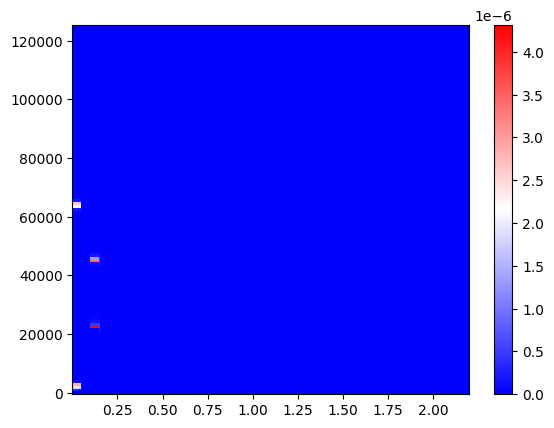

In [35]:
import scipy as sp
# clip response to stimulus start
test_data = test_data[200:, : , :]
f, t, Sxx = sp.signal.spectrogram(raw_stimulus[0], fs=sr_audio)
plt.pcolormesh(t, f, Sxx, cmap='bwr')
plt.colorbar()
plt.show()

In [36]:
print(test_data.shape)
sr_data = 100
spec = resample(Sxx, test_data.shape[0], axis=1)

(220, 170, 152)


In [37]:
import pickle as pkl
from math import gcd
from skimage.measure import block_reduce
# apply STRF
tmin = 0
tmax = 0.3

strf_model = nl.encoding.TRF(tmin, tmax, sr_data, estimator=Ridge(10), show_progress=True)
# resample
print(f"Size of raw stimulus is: {raw_stimulus[0].shape}")
print(f"Size of audio spectrogram is: {Sxx.shape}")
print(f"After resampling: {spec.shape}")

small_data = np.array([block_reduce(frame, gcd(test_data.shape[1], test_data.shape[2]), np.mean) for frame in test_data])
small_data = small_data.reshape(small_data.shape[0], small_data.shape[1]*small_data.shape[2])

try:
	with open('test_coefs.pkl', 'rb') as file:
		coef_ridge = pkl.load(file)
except OSError:
	strf_model.fit(X=np.expand_dims(np.transpose(spec), 0), y=np.expand_dims(test_data, 0))
	coef_ridge = strf_model.coef_
	with open('test_coefs.pkl', 'wb') as file:
		pkl.dump(strf_model.coef_, file)

Size of raw stimulus is: (550002,)
Size of audio spectrogram is: (129, 2455)
After resampling: (129, 220)


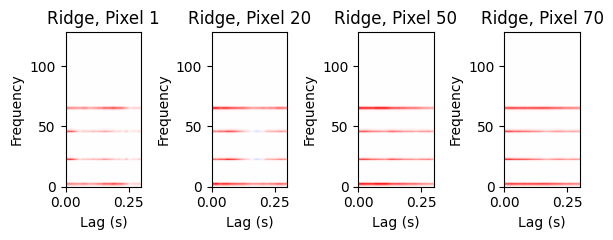

In [38]:
pixels = [1, 20, 50, 70]
avg_strf_list = []

fig, axes = plt.subplots(1,4,figsize=(6,2.5))
for i, pixel in enumerate(pixels):
	model_1_coef = coef_ridge[pixel]
	strf_plot(model_1_coef, tmin=tmin, tmax=tmax, ax=axes[i])
	axes[i].set_title(f'Ridge, Pixel {pixel}')
fig.tight_layout()
plt.show()

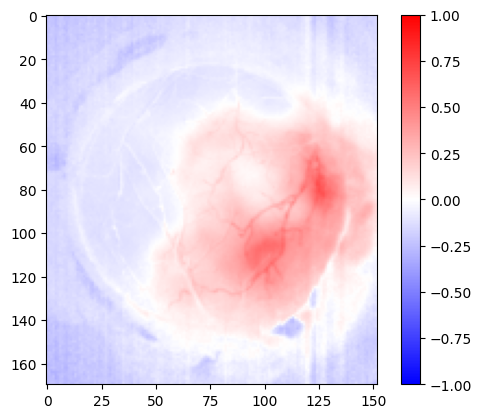

In [39]:
avg_strf_list = np.array([np.mean(coef) for coef in coef_ridge])
avg_strf_list = avg_strf_list.reshape(test_data.shape[1], test_data.shape[2])
avg_strf_list = (avg_strf_list - np.mean(avg_strf_list)) / (np.max(avg_strf_list) - np.min(avg_strf_list))
plt.imshow(avg_strf_list, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.savefig(f"../thesis_text/Imgs/m{animal_id}_r{recording_id}_t{trial_id}/avg_strf.png")

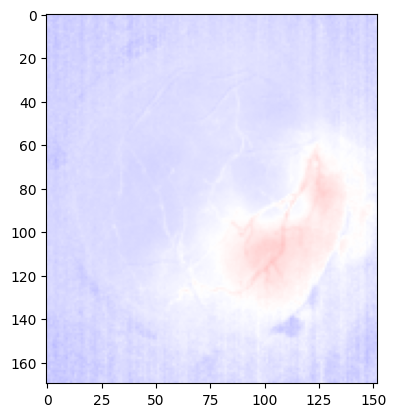

In [40]:
from IPython.display import Video
from matplotlib import animation, cm
temporal_avg_strf_list = np.mean(coef_ridge, axis=1)
temporal_avg_strf_list = (temporal_avg_strf_list - np.mean(temporal_avg_strf_list)) / (np.max(temporal_avg_strf_list) - np.min(temporal_avg_strf_list))
temporal_avg_strf_list = np.transpose(temporal_avg_strf_list)
temporal_avg_strf_list = temporal_avg_strf_list.reshape(-1, test_data.shape[1], test_data.shape[2])

frames = []
fig = plt.figure()
for frame in temporal_avg_strf_list:
    frames.append([plt.imshow(frame, cmap='bwr', vmin=-1, vmax=1, animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
ani.save(f"../thesis_text/Imgs/m{animal_id}_r{recording_id}_t{trial_id}/temporal_avg_strf.mp4")
plt.show()

## DSTRF

In [41]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import numpy as np
import cv2
from PIL import Image

from scipy.signal import resample, chirp
from sklearn.linear_model import Ridge, ElasticNet

import naplib as nl
from naplib.visualization import strf_plot

In [42]:
import dynamic_strf as dstrf

In [43]:
import IPython.display as ipd
from hdf5storage import loadmat

import torch
import torchaudio
import pytorch_lightning as plc
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
torch.set_float32_matmul_precision('medium')
print(device)

cuda


In [44]:
small_data = np.array([block_reduce(frame, block_size=(10, 10), func=np.mean) for frame in test_data])
small_data = small_data.reshape(small_data.shape[0], small_data.shape[1]*small_data.shape[2])
print(small_data.shape)

(220, 272)


In [45]:
# define builder and trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pl_bolts.callbacks.printing import PrintTableMetricsCallback
### data naming
crossval = False
jackknife = False
reduced = True
logger = False
res = f"{small_data.shape[0]}x{small_data.shape[1]}"

desc_param = ("jackk" if jackknife else "") + ("crossval" if crossval else "") + ("reduced" if reduced else "") + res

tb_logger = TensorBoardLogger(f"output/{desc_param}-logs", name=f"{desc_param}", log_graph=False)

def trainer():
    return plc.Trainer(
        accelerator = 'auto',
        precision = '16-mixed',
        gradient_clip_val = 10.0,
        max_epochs = 100,
        logger = logger,
        log_every_n_steps=1,
        detect_anomaly = False,
        enable_model_summary = False,
        enable_progress_bar = True,
        enable_checkpointing = True,
        callbacks=[PrintTableMetricsCallback()],
    )

def builder():
    return dstrf.modeling.DeepEncoder(
        input_size=spec.shape[0],
        hidden_size=128,
        channels=small_data.shape[1],
    ).to(device)

In [46]:
dstrf_X = torch.from_numpy(np.expand_dims(np.transpose(spec), 0))
dstrf_y = torch.from_numpy(np.expand_dims(small_data, 0))

In [47]:
import os

dstrf.modeling.fit_multiple(
    builder=builder,
    data=(dstrf_X, dstrf_y),
    crossval=False,
    jackknife=False,
    trainer=trainer,
    save_dir=f'output/{desc_param}',
    verbose=1
)  

Directory "output/reduced220x272" already exists.
Fitting model for leave out: []... 

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cristi/.virtualenvs/base/lib64/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /automnt/Shared/home/cristi/Documents/Radboud/Assignments/B3/Thesis/thesis_code/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
# import glob, os
# checkpoints = sorted(glob.glob(os.path.join('output/5x128-jackknife-cv', 'model-*.pt')))
# print(checkpoints)

In [ ]:
dstrf.estimate.dSTRF_multiple(
    model=builder(),
    checkpoints=f'output/{desc_param}',
    data=dstrf_X,
    crossval=False,
    save_dir=f'output/{desc_param}-dstrf',
    chunk_size=2
) 

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 15 (GCC)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --docdir=/usr/share/doc/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -flto=auto -ffat-lto-objects -fexceptions -g -grecord-gcc-switches -pipe -Wall -Wno-complain-wrong-lang -Werror=format-security -Wp,-U_FORTIFY_SOURCE,-D_FORTIFY_SOURCE=3 -Wp,-D_GLIBCXX_ASSERTIONS -specs=/usr/lib/rpm/redhat/redhat-hardened-cc1 -fstack-protector-strong -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1 -m64 -march=x86-64 -mtune=generic -fasynchronous-unwind-tables -fstack-clash-protection -fcf-protection -mtls-dialect=gnu2 -fno-omit-frame-pointer -mno-omit-leaf-frame-pointer' --extra-ldflags='-Wl,-z,relro -Wl,--as-needed -Wl,-z,pack-relative-relocs -Wl,-z,now -specs=/usr/lib/rpm/redhat/redhat-hardened-ld -specs=/usr/lib/rpm/redhat/redhat-annobin-cc1 -Wl,--build-id=sha1 -specs=/

KeyboardInterrupt: 

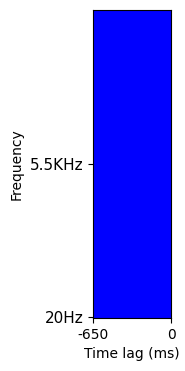

In [ ]:
dstrf.visualize.dSTRF(
    f'output/{desc_param}-dstrf/dSTRF-000.pt',
    channels=slice(0, None, 1),
    time_range=slice(0, None, 1),
    output_prefix=f'output/video/{desc_param}-dstrf',
    xlabel='Time lag (ms)',
    xticks=[0, 65],
    xtick_labels=[-650, 0],
    ylabel='Frequency',
    yticks=[0, 64],
    ytick_labels=['20Hz', '5.5KHz']
)

In [ ]:
ipd.display(ipd.Video('output/video/channel-0000.mp4', height=300))